# Calculation of magentic field around helix shaped conductors

Takes as input:
- Transferred power
- Voltage level
- Geometry of line
- Constraints/limits for the magentic field

In [42]:
# Importing the necessary modules:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xlsxwriter
import json
from scipy.integrate import quad
from math import sqrt, sin, cos, atan2, pi
plt.close()

In [43]:
# "Cable database"
cable_reference_cable = ["" for x in range(10)]
single_core_diameter_cable = np.zeros(10,float)
layup_length_cable = np.zeros(10,float)
outer_cable_diameter_cable = np.zeros(10,float)
active_power_cable = np.zeros(10,float)
sheath_current_rms_cable = np.zeros(10,float)
magnetic_armour_cable = [False for x in range(10)]

cable_reference_cable[1] = 'C1'
single_core_diameter_cable[1] = 84     # in mm
layup_length_cable[1] = 2178           # in mm
outer_cable_diameter_cable[1] = 215    # in mm
active_power_cable[1] = 229e6          # in W
sheath_current_rms_cable[1] = 99       # in Amp
magnetic_armour_cable[1] = False

cable_reference_cable[2] = 'C2'
single_core_diameter_cable[2] = 107.3     # in mm
layup_length_cable[2] = 2782     # in mm
outer_cable_diameter_cable[2] = 261     # in mm
active_power_cable[2] = 263e6     # in W
sheath_current_rms_cable[2] = 183     # in Amp
magnetic_armour_cable[2] = False

cable_reference_cable[3] = 'C3'
single_core_diameter_cable[3] = 120.6     # in mm
layup_length_cable[3] = 3127     # in mm
outer_cable_diameter_cable[3] = 304     # in mm
active_power_cable[3] = 263e6     # in W
sheath_current_rms_cable[3] = 0     # in Amp
magnetic_armour_cable[3] = False

cable_reference_cable[4] = 'C4'
single_core_diameter_cable[4] = 99.7     # in mm
layup_length_cable[4] = 2584     # in mm
outer_cable_diameter_cable[4] = 261     # in mm
active_power_cable[4] = 229e6     # in W
sheath_current_rms_cable[4] = 0     # in Amp
magnetic_armour_cable[4] = False

cable_reference_cable[5] = 'C5'
single_core_diameter_cable[5] = 86.3     # in mm
layup_length_cable[5] = 2237     # in mm
outer_cable_diameter_cable[5] = 230     # in mm
active_power_cable[5] = 229e6     # in W
sheath_current_rms_cable[5] = 251     # in Amp
magnetic_armour_cable[5] = False

cable_reference_cable[6] = 'Mulligan'
single_core_diameter_cable[6] = 74.4     # in mm
layup_length_cable[6] = 3000     # in mm
outer_cable_diameter_cable[6] = 182.8     # in mm
active_power_cable[6] = 90e6     # in W
sheath_current_rms_cable[6] = 0     # in Amp
magnetic_armour_cable[6] = False

cable_reference_cable[7] = 'Hywind-1'
single_core_diameter_cable[7] = 70.3     # in mm
layup_length_cable[7] = 1450     # in mm
outer_cable_diameter_cable[7] = 196.0     # in mm
active_power_cable[7] = 50e6     # in W
sheath_current_rms_cable[7] = 69.4     # in Amp
magnetic_armour_cable[7] = False

In [44]:
# mydict = [{'cable_reference': i, 'single_core_diameter': j, 'layup_length': k, 'outer_cable_diameter': l} for i, j, k, l in zip(cable_reference_cable, single_core_diameter_cable, layup_length_cable, outer_cable_diameter_cable)]
# json_object = json.dumps(mydict, indent=4)
# with open(r'C:\Users\geirn\OneDrive - Equinor\Equinor Documents\Python\Magnetic fields from cables\TestCables01.json', "w") as outfile:
#         outfile.write(json_object)

In [45]:
# Select cable to calculte:
cable_no = 7

# Input section:
installation_depth = 1.0 # in m
no_of_circuits = 1     #Number of circuits
no_of_conductors_per_circuit = 3   #Number of conductors pr. circuit (normally 3)
no_of_conductors = no_of_circuits * no_of_conductors_per_circuit   #Number of conductors in total
active_power = [active_power_cable[cable_no]]   #Active, transferred power in Watt [W] pr. circuit - 263, 229 is equivalent to 1150, 1000
reactive_power = [37.5e6] #Reactive, transferred power in VAr's [VAr] pr. circuit
rated_voltage = 36e3  #Rated line voltage in Volt [V]
#cos_phi = 0.9
sheath_current_rms = sheath_current_rms_cable[cable_no]    # in Ampere
phase_current_abs = sqrt(active_power[0]**2 + reactive_power[0]**2) / (rated_voltage * sqrt(3))
sheath_current_angle = -atan2(sheath_current_rms, phase_current_abs) - pi/2 # in redians, negative angle values because they are lagging the phase current with a little more than 90 degrees
print (sheath_current_angle * 180/pi)

sheath_angle_rad = np.zeros(no_of_conductors,float) # Defining the variable
phase_angle_rad = np.zeros(no_of_conductors,float)

#define current phase angle for each conductor - needs to be aligned with no_of_conductors:
# This defines the phase order of the conductors

phase_angle_deg = [0, -120, +120]

for i in range(0, no_of_circuits * no_of_conductors):
    phase_angle_rad[i] = phase_angle_deg[i]*pi/180
    sheath_angle_rad[i] = phase_angle_rad[i] + sheath_current_angle

# defining standard parameters
u_0 = 4 * pi * 1e-7 # Permeability of vacuum

#defining the cable
cable_reference = cable_reference_cable[cable_no] # Typically a number like 'C5' as a reference in reports etc.
single_core_diameter = single_core_diameter_cable[cable_no] / 1000       # in meters
helix_radius = single_core_diameter / sqrt(3)
layup_length = layup_length_cable[cable_no] / 1000           # in meters
outer_cable_diameter = outer_cable_diameter_cable[cable_no] / 1000         # in meters
outer_cable_radius = outer_cable_diameter / 2

magnetic_armour = magnetic_armour_cable[cable_no] # Theory regarding magnetic armour and shielding in general can be found in a paper - ask Geir N if necessary
if magnetic_armour:
    shielding_factor = 1.2 # The value could be as high as 2.0, but to be on the conservative side it should not be higher than 1.2. Check with Even T - Nexans Troll Wind report has lower factors than this - Sintef report for Nywind has 1,235 - 1,293
else:
    shielding_factor = 1

print (outer_cable_radius)

integration_length = 10 * layup_length * 2 * pi  # in meters * 2pi, factor based on some testing must not be too high - over 15 - or the integration quad does not work
height = layup_length / (2 * pi)

#defining necessary vectors, matrixes:
phase_current = np.zeros([no_of_circuits * no_of_conductors],complex)
sheath_current = np.zeros([no_of_circuits * no_of_conductors],complex)
current = np.zeros([no_of_circuits * no_of_conductors],complex)

min_x = 0.01 + int(100*outer_cable_radius) /100 #x-coordinate in meters [m]
max_x = 6 + min_x
#no_of_steps_x = int(100 * (max_x - min_x))
#step_length_x = (max_x - min_x) / no_of_steps_x # Approximately 0.01 m step lenght

no_of_steps_x = 600

x_coordinate = np.zeros([no_of_steps_x],float)
Cx_res = np.zeros(3,complex)
Cy_res = np.zeros(3,complex)
Cz_res = np.zeros(3,complex)
Bx = np.zeros(2,complex)
By = np.zeros(2,complex)
Bz = np.zeros(2,complex)
B = np.zeros(2,float)
B_tot = np.zeros([no_of_steps_x],float)

Icnrip_high_all = np.zeros([no_of_steps_x],float)

# Seting up the limits based on Icnirp/other regulations
Icnirp_low = 0.4  #low, level for impact assessment
Icnrip_high = 200 #high public exposure
Icnirp_work = 1000 #exposure in work environement


-93.96070657243018
0.098


In [46]:
# Calculated parameters from input:
for i in range(0, no_of_circuits):
    for j in range(0, no_of_conductors):
        phase_current[3*i + j] = complex (cos(phase_angle_rad[3*i+j]), sin(phase_angle_rad[3*i+j])) * complex(active_power[i], -reactive_power[i]) / (rated_voltage * sqrt(3)) #Current in conductyors in ampere [A] as complex phasors
        sheath_current[3*i + j] = complex (sheath_current_rms * cos(sheath_angle_rad[3*i+j]), sheath_current_rms * sin(sheath_angle_rad[3*i+j]))
        current[3*i + j] = phase_current[3*i + j] + sheath_current[3*i + j]
        print (phase_current[3*i + j], abs(phase_current[3*i + j]))
        print (sheath_current[3*i + j], abs(sheath_current[3*i + j]))
        print (current[3*i + j], abs(current[3*i + j]))

(801.8753738744803-601.4065304058602j) 1002.3442173431002
(-4.7936195827608525-69.23424883174347j) 69.4
(797.0817542917194-670.6407792376036j) 1041.6805545853226
(-921.7710202705733-393.7411792415145j) 1002.3442173431002
(-57.56180850884252+38.76852075062119j) 69.4
(-979.3328287794159-354.9726584908933j) 1041.6805545853224
(119.89564639609341+995.1477096473744j) 1002.3442173431002
(62.35542809160338+30.465728081122265j) 69.4
(182.2510744876968+1025.6134377284966j) 1041.6805545853224


In [47]:
  
# calculating the magentic field by adding up the contribution from each conductor
workbook  = xlsxwriter.Workbook(r'C:\Users\geirn\OneDrive - Equinor\Equinor Documents\Python\Magnetic fields from cables\Test02RedBlue.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write(0, 0, "x-coor")
worksheet.write(0, 1, "B[0] - red")
worksheet.write(0, 2, "B[1] - blue")

directions_to_calculate = [0, 1]
has_crossed_Icnrip_high = False
has_crossed_installation_depth = False
has_started_flattening = False
xLeft = 99
log_derived = -999

for x in range(-1, 600):
    if x == -1:
        calculation_position_x = outer_cable_radius # The first value is calculated at the cable surface
    else:
        calculation_position_x = min_x + x * 0.01
    x_coordinate[x] = calculation_position_x
    for a in directions_to_calculate: # Calculate B[a] where a=0 gives radial direction between two phase conductors (red arrow) and a=1 gives direction at a phase conductor (blue arrow)
        angle_change = (1-a)*pi/3
        for i in range (3): # 3 phase conductors to be calculated: L1=0, L2=1 and L3=2
            circ3 = i*2*pi/3
            angle_dev = circ3 + angle_change

    # Functions we need to integrate - (ask Geir N for the article that describes the theory if necessary: "ANALYTICAL MAGNETIC FIELD CALCULATION OF HELICAL CURRENT CONDUCTORS", Krzysztof BUDNIK, Wojciech MACHCZYŃSKI)
    # Geir N has also written an addendum to the article in order to correct a misprint and being able to use it for a 3-core cable 
            def Cx(angle):   
                return (helix_radius * cos (angle+angle_dev) * (-height * angle) + height * helix_radius * sin(angle+angle_dev)) / \
                    (( (calculation_position_x - helix_radius * cos(angle+angle_dev))**2 + (-helix_radius * sin(angle+angle_dev))**2 + (-height * angle)**2)**1.5 )

            def Cy(angle):
                return (helix_radius * sin (angle+angle_dev) * (-height * angle) + height * (calculation_position_x - helix_radius * cos(angle+angle_dev))) / \
                    (( (calculation_position_x - helix_radius * cos(angle+angle_dev))**2 + (-helix_radius * sin(angle+angle_dev))**2 + (-height * angle)**2)**1.5 )

            def Cz(angle):
                return ((helix_radius * sin (angle+angle_dev))**2 - helix_radius * cos (angle+angle_dev) * (calculation_position_x - helix_radius * cos(angle+angle_dev))) / \
                    (( (calculation_position_x - helix_radius * cos(angle+angle_dev))**2 + (-helix_radius * sin(angle+angle_dev))**2 + (-height * angle)**2)**1.5 )
    
            Cx_res[i], err = quad(Cx, -integration_length, integration_length)
            Cy_res[i], err = quad(Cy, -integration_length, integration_length)
            Cz_res[i], err = quad(Cz, -integration_length, integration_length)
            if x==10 and a==0 and i==0:
                print (err)
            
        Bx[a] = 1000000 * u_0 * (current[0] * Cx_res[0] + current[1] * Cx_res[1] + current[2] * Cx_res[2]) / (4 * pi)
        By[a] = 1000000 * u_0 * (current[0] * Cy_res[0] + current[1] * Cy_res[1] + current[2] * Cy_res[2]) / (4 * pi)
        Bz[a] = 1000000 * u_0 * (current[0] * Cz_res[0] + current[1] * Cz_res[1] + current[2] * Cz_res[2]) / (4 * pi)

        B[a] = (sqrt (abs(Bx[a])**2 + abs(By[a])**2 + abs(Bz[a])**2)) / shielding_factor

        if x == -1: # Store the first B value in Btot_outer, the rest to be stored in B_tot
            B_tot_outer = B[1]
        else:
            if directions_to_calculate == [0, 1]:
                if B[1] > B[0]:
                    B_tot[x] = B[1]
                else: # This is the frst value of x where B[0] becomes highest
                    B_tot[x] = B[0]
                    directions_to_calculate = [0]

            else: # After B[0] becomes highest - only calculate B[0] for the rest of the x's
                B_tot[x] = B[0]

        if x == round(layup_length*100):
            extension_log_derived = np.log10(B_tot[x]) - np.log10(B_tot[x-1])

        if x > 10 and not has_started_flattening:
            log_derived = 1000 * (np.log(B_tot[x]) - np.log(B_tot[x-1]))
            if log_derived > -1:
                xLeft = calculation_position_x # Used for drawing a red circle in the "flat" area
                has_started_flattening = True
        
        if B_tot[x] < Icnrip_high and not has_crossed_Icnrip_high:
            Icnrip_high_crossing = x_coordinate[x]
            has_crossed_Icnrip_high = True

        if calculation_position_x >= installation_depth and not has_crossed_installation_depth:
            installation_depth_crossing = x
            has_crossed_installation_depth = True

        worksheet.write(x+2, 0, x_coordinate[x])
        worksheet.write(x+2, 1, B[0])
        worksheet.write(x+2, 2, B[1])

workbook.close()

4.980801438847005e-10


In [48]:
#Make curves for 0 m and 1 m
x_coordinate_curves = np.zeros(2*300+1,float)


Bcurve = np.zeros((2,2*300+1),float)

for x in range(0,301): # x in cm
    calculation_position_x = -3 + x/100 # in meters

    for d in range (2): # Calculationg for installation depth and 1 meter above sea bottom level
        dept = installation_depth + d * 1
        for i in range (3): # 3 phase conductors to be calculated: L1=0, L2=1 and L3=2
            circ3 = i*2*pi/3
            angle_dev = circ3 + pi/3   # pi/3 is the angle change - fixed in this calculation 

            def Cx(angle):   
                return (helix_radius * cos (angle+angle_dev) * (-height * angle) - height * (dept - helix_radius * sin(angle+angle_dev))) / \
                    (( (calculation_position_x - helix_radius * cos(angle+angle_dev))**2 + (dept - helix_radius * sin(angle+angle_dev))**2 + (-height * angle)**2)**1.5 )

            def Cy(angle):
                return (helix_radius * sin (angle+angle_dev) * (-height * angle) + height * (calculation_position_x - helix_radius * cos(angle+angle_dev))) / \
                    (( (calculation_position_x - helix_radius * cos(angle+angle_dev))**2 + (dept - helix_radius * sin(angle+angle_dev))**2 + (-height * angle)**2)**1.5 )

            def Cz(angle):
                return ((helix_radius * sin (angle+angle_dev))*(helix_radius * sin (angle+angle_dev) - dept) - helix_radius * cos (angle+angle_dev) * (calculation_position_x - helix_radius * cos(angle+angle_dev))) / \
                    (( (calculation_position_x - helix_radius * cos(angle+angle_dev))**2 + (dept - helix_radius * sin(angle+angle_dev))**2 + (-height * angle)**2)**1.5 )
        
            Cx_res[i], err = quad(Cx, -integration_length, integration_length)
            Cy_res[i], err = quad(Cy, -integration_length, integration_length)
            Cz_res[i], err = quad(Cz, -integration_length, integration_length)

        Bx[0] = 1000000 * u_0 * (current[0] * Cx_res[0] + current[1] * Cx_res[1] + current[2] * Cx_res[2]) / (4 * pi)
        By[0] = 1000000 * u_0 * (current[0] * Cy_res[0] + current[1] * Cy_res[1] + current[2] * Cy_res[2]) / (4 * pi)
        Bz[0] = 1000000 * u_0 * (current[0] * Cz_res[0] + current[1] * Cz_res[1] + current[2] * Cz_res[2]) / (4 * pi)

        B[0] = (sqrt (abs(Bx[a])**2 + abs(By[a])**2 + abs(Bz[a])**2)) / shielding_factor

        Bcurve[d,x] = B[0]
        Bcurve[d,600-x] = B[0]
    
    x_coordinate_curves[x] = calculation_position_x
    x_coordinate_curves[600-x] = -calculation_position_x

In [49]:
#Write results to excel file
workbook  = xlsxwriter.Workbook(r'C:\Users\geirn\OneDrive - Equinor\Equinor Documents\Python\Magnetic fields from cables\Test02.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0, 3, outer_cable_radius)
worksheet.write(0, 4, B_tot_outer)
worksheet.write(2, 3, cable_reference)

for x in range(0,no_of_steps_x):
    worksheet.write(x, 0, x_coordinate[x])
    worksheet.write(x, 1, B_tot[x])
    worksheet.write(x, 2, Bcurve[0,x])

workbook.close()

In [50]:

xRight = 6
yTop = 0.002
yBottom = 0.0005

xCenter = (xRight + xLeft) / 2 
xRadius = (xRight - xLeft) / 2

if has_started_flattening:
    yCenter = np.log((B_tot[int((xLeft - min_x) * 100)] + B_tot[599]) / 2) # Average value between point where flattening starts and end-point of curve

yRadius = 0.5

angle = np.linspace( 0 , 2 * np.pi , 150 ) 
 
x = xCenter + xRadius * np.cos(angle)
y = np.exp(yCenter + yRadius * np.sin(angle))

#figure, axes = plt.subplots( 1 ) 
 

<function matplotlib.pyplot.show(close=None, block=None)>

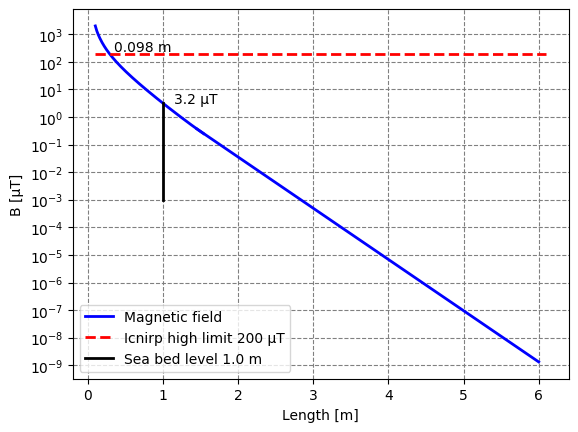

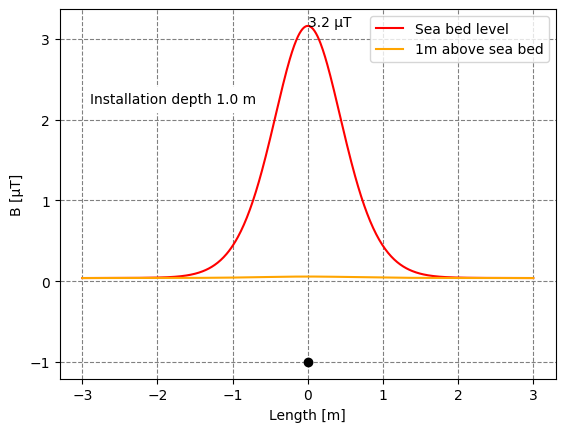

In [51]:
#Plotting the B_tot values as function of distance from cable center
plt.figure(1)

if has_started_flattening:
    #Plotting only the part which is accurate (meaning before the flattening caused by inaccurate numerical integration)
    plt.plot (x_coordinate[0:round(layup_length*100)], B_tot[0:round(layup_length*100)], label = "Magnetic field", color="blue", linewidth=2, linestyle="-")
    #plt.plot( x, y, color="red") # Circle showing "flattened area"
    #x_line = [xCenter - xRadius, 6]
    #y_line = [B_tot[round(layup_length*100)] * ((10**(100*extension_log_derived))**(xCenter - xRadius - layup_length)), B_tot[round(layup_length*100)] * ((10**(100*extension_log_derived))**(6 - layup_length))]
    x_line = [layup_length, 6]
    y_line = [B_tot[round((layup_length - min_x) * 100)], B_tot[round((layup_length - min_x) * 100)] * ((10**(100*extension_log_derived))**(6 - layup_length))]
    plt.plot (x_line, y_line, color="blue", linewidth=2, linestyle="-") 
else:
    #Plotting the whole curve (since no flattening caused by inaccurate numerical integration has occured)
    plt.plot (x_coordinate[0:round(layup_length*100)], B_tot[0:round(layup_length*100)], label = "Magnetic field", color="blue", linewidth=2, linestyle="-")

x_line = [min_x,max_x] # x coordinates for line
y_line = [Icnrip_high,Icnrip_high] # y coordinates for line
plt.plot (x_line, y_line, color="red", linewidth=2, label = "Icnirp high limit " + str(Icnrip_high) + " \u03BCT", linestyle="--") 

x_line = [installation_depth,installation_depth]
y_line = [1e-3,B_tot[installation_depth_crossing]]
plt.plot (x_line, y_line, color="black", linewidth=2, label = "Sea bed level " + str(installation_depth) + " m", linestyle="-") 

plt.yscale('symlog', linthresh=1e-10)
plt.xlabel("Length [m]")
plt.ylabel("B [\u03BCT]")
plt.legend()
plt.grid(which='major', color='grey', linestyle='--')
plt.text(Icnrip_high_crossing + 0.25, Icnrip_high + 50, "%.3f" % Icnrip_high_crossing + " m")
plt.text(installation_depth + 0.15, B_tot[installation_depth_crossing] + 0.15, "%.1f" % B_tot[installation_depth_crossing] + " \u03BCT")
#plt.circle((4, 1), 1, color='red')
plt.show

#Plotting the B_tot values at y=0m (ie. at seabed level) and 1m
plt.figure(2)

plt.plot (x_coordinate_curves, Bcurve[0], label = "Sea bed level", linestyle="-", color='red')
plt.plot (x_coordinate_curves, Bcurve[1], label = "1m above sea bed", linestyle="-", color='orange')
#plt.plot (x_coordinate_curves, distance, label = "Distance")

if B_tot[installation_depth_crossing] > Icnrip_high:
    x_line = [-3, 3] # x coordinates for line
    y_line = [Icnrip_high,Icnrip_high] # y coordinates for line

plt.legend()
plt.grid(which='major', color='grey', linestyle='--')
plt.text(0, B_tot[installation_depth_crossing] - 0, "%.1f" % B_tot[installation_depth_crossing] + " \u03BCT")
# plt.text(-2.9, B_tot[installation_depth_crossing] - 1, "Installation depth " + "%.1f" % installation_depth + " m", backgroundcolor = "white") # This one didn't work for very low values (large installation depths for instance)
plt.text(-2.9,2.2, "Installation depth " + "%.1f" % installation_depth + " m", backgroundcolor = "white")
plt.xlabel("Length [m]")
plt.ylabel("B [\u03BCT]")

ax = plt.gca()
ax.plot((0), (-1), 'o', color='black')

plt.show

In [52]:
# Intentionally left empty